In [16]:
import numpy as np
import os
import sep
import re
#import photutils
#import numpy.random as npr
import pandas as pd
import petrofit as pf
import matplotlib.pyplot as plt
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.cm as mcm
from matplotlib.patches import Ellipse
import numpy.ma as nma
#import fitsio
from astropy.io import fits
import statmorph as smh
from data_get import *

plt.rcParams['figure.figsize'] = [8., 8.]
plt.rcParams["axes.linewidth"]  = 2
plt.rcParams["xtick.major.size"]  = 8
plt.rcParams["xtick.minor.size"]  = 3
plt.rcParams["ytick.major.size"]  = 8
plt.rcParams["ytick.minor.size"]  = 3
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams.update({'font.size': 24})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams["mathtext.default"] = 'rm'
plt.rcParams["mathtext.fontset"] = 'cm'

In [2]:
from photutils.background import Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources, SourceFinder, SourceCatalog
from photutils.utils import circular_footprint
from astropy.convolution import convolve
from photutils.psf import MoffatPSF
from pysersic import check_input_data,FitSingle
from pysersic.results import plot_image
from pysersic.priors import autoprior
from pysersic.loss import student_t_loss
from jax.random import PRNGKey # Need to use a seed to start jax's random number generation

#sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
#mean, median, std = sigma_clipped_stats(data, sigma=3.0, mask=mask)

/opt/anaconda3/envs/morphy/lib/python3.13/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [3]:
sources = pd.read_csv('v1saga_dwarfs.csv')

In [4]:
cutout_list = os.listdir("cutouts/")
#print(cutout_list)

In [5]:
channels = {'g':mcm.cividis,'r':mcm.viridis,'i':mcm.inferno,'z':mcm.Greys_r}

def image_plot(ax,img,cmp):
    m, s = np.mean(img), np.std(img)
    ax.imshow(img, interpolation='nearest', cmap=cmp, vmin=m-s, vmax=m+s, origin='lower')
    

def image_bkg(img_dat,c=['g','r','i','z']):
    img_sub = []
    img_rms = []
    glob_rms = []

    img_arr = img_dat[0].data
    img_hdr = img_dat[0].header
    img_invvar = img_dat[1].data


    w = wcs.WCS(img_hdr,naxis=2)
    #print(w)
    #world_coords = w.all_pix2world([[0],[255]], 1)[0]
    #print(world_coords)

    fig,ax=plt.subplots(2,len(c),figsize=(6*len(c),14),sharey=True)
    #fig = plt.figure(figsize=(6*len(c),14)) 
   
    for i,key in enumerate(channels):
        #image_plot(ax[0,i],img_arr[i,:,:],channels[key])

        mean, median, std = sigma_clipped_stats(img_arr[i,:,:], sigma=1.0)
        print(mean, median, std)
        
        threshold = detect_threshold(img_arr[i,:,:], nsigma=1.0)
        segment_img = detect_sources(img_arr[i,:,:], threshold, npixels=10,connectivity=8)
        mask = segment_img.make_source_mask(size=2)
        '''
        mean, median, std = sigma_clipped_stats(img_arr[i,:,:], sigma=1.0)
        print(mean, median, std)

        threshold = detect_threshold(img_arr[i,:,:], nsigma=1.0,mask=mask)
        segment_img = detect_sources(img_arr[i,:,:], threshold, npixels=10,connectivity=8,mask=mask)
        mask = segment_img.make_source_mask(size=2)

        mean, median, std = sigma_clipped_stats(img_arr[i,:,:], sigma=1.0,mask=mask)
        print(mean, median, std)
        '''
        var = np.reciprocal(img_invvar[i,:,:])
        bkg = Background2D(img_arr[i,:,:].astype(img_arr[i,:,:].dtype.newbyteorder('=')), (32, 32), filter_size=(5,5), mask=mask)

        mean, median, std = sigma_clipped_stats(img_arr[i,:,:]-np.abs(bkg.background), sigma=1.0)
        print(mean, median, std)
    
        print('PHOTUTILS'+key+' Background:',bkg.background_median,key+' RMS^2:',np.square(bkg.background_rms_median),key+' Var:',np.mean(var))
        glob_rms.append(bkg.background_median)

        image_plot(ax[0,i],nma.masked_array(img_arr[i,:,:],mask=mask),channels[key])

        '''
        sep_bkg = sep.Background(img_arr[i,:,:].astype(img_arr[i,:,:].dtype.newbyteorder('=')),bw=16, bh=16,fw=3,fh=3)
        image_plot(ax[0,i],sep_bkg.back(),channels[key])
        print('SEP'+key+' Background:',sep_bkg.globalback,key+' RMS^2:',np.square(sep_bkg.globalrms))
        '''
        img_sub.append(img_arr[i,:,:]-np.abs(bkg.background))
        img_rms.append(np.sqrt(var))

        #snr = img_sub[i]/np.sqrt(var)
 
        image_plot(ax[1,i],img_sub[i],channels[key])
    plt.subplots_adjust(wspace=0.0,hspace=0.05)
    plt.show()

    return np.stack(img_sub,0),img_hdr, np.stack(img_rms,0),glob_rms


In [8]:
filename = cutout_list[npr.choice(len(cutout_list))]
pos = [float(p) for p in re.findall(r"[-+]?(?:\d*\.*\d+)", filename)]
pos = [0.1193843,20.6195711]
#filename = 'cutout_{:.4f}_{:.4f}.fits'.format(pos[0],pos[1])
#print(filename,pos)
#pos = np.array([8.3580602,-64.2416358])
pos_coord = SkyCoord(ra=pos[0]*u.degree, dec=pos[1]*u.degree, frame='icrs')
#download_cutout(pos.reshape(1,2))

print(filename)

cutout_335.7599_-3.2579.fits


0.00018089703 0.00017606706 0.00017099915
6.673244e-05 6.1306084e-05 0.00017032032
PHOTUTILSg Background: 0.00011595166 g RMS^2: 2.960749e-06 g Var: 5.1419966e-06
0.0003366459 0.00035090602 0.00032544814
0.00030913574 0.00032271378 0.00032501918
PHOTUTILSr Background: -9.665412e-06 r RMS^2: 1.0588908e-05 r Var: 1.8642708e-05
0.0006172088 0.00061642576 0.0005622457
0.0005726473 0.0005686053 0.00055960444
PHOTUTILSi Background: -3.83541e-05 i RMS^2: 3.8472233e-05 i Var: 6.6126886e-05
0.0007974457 0.0007973802 0.0007132653
0.00071873335 0.0007169422 0.0007115835
PHOTUTILSz Background: 5.5435838e-05 z RMS^2: 6.163026e-05 z Var: 0.00010750687


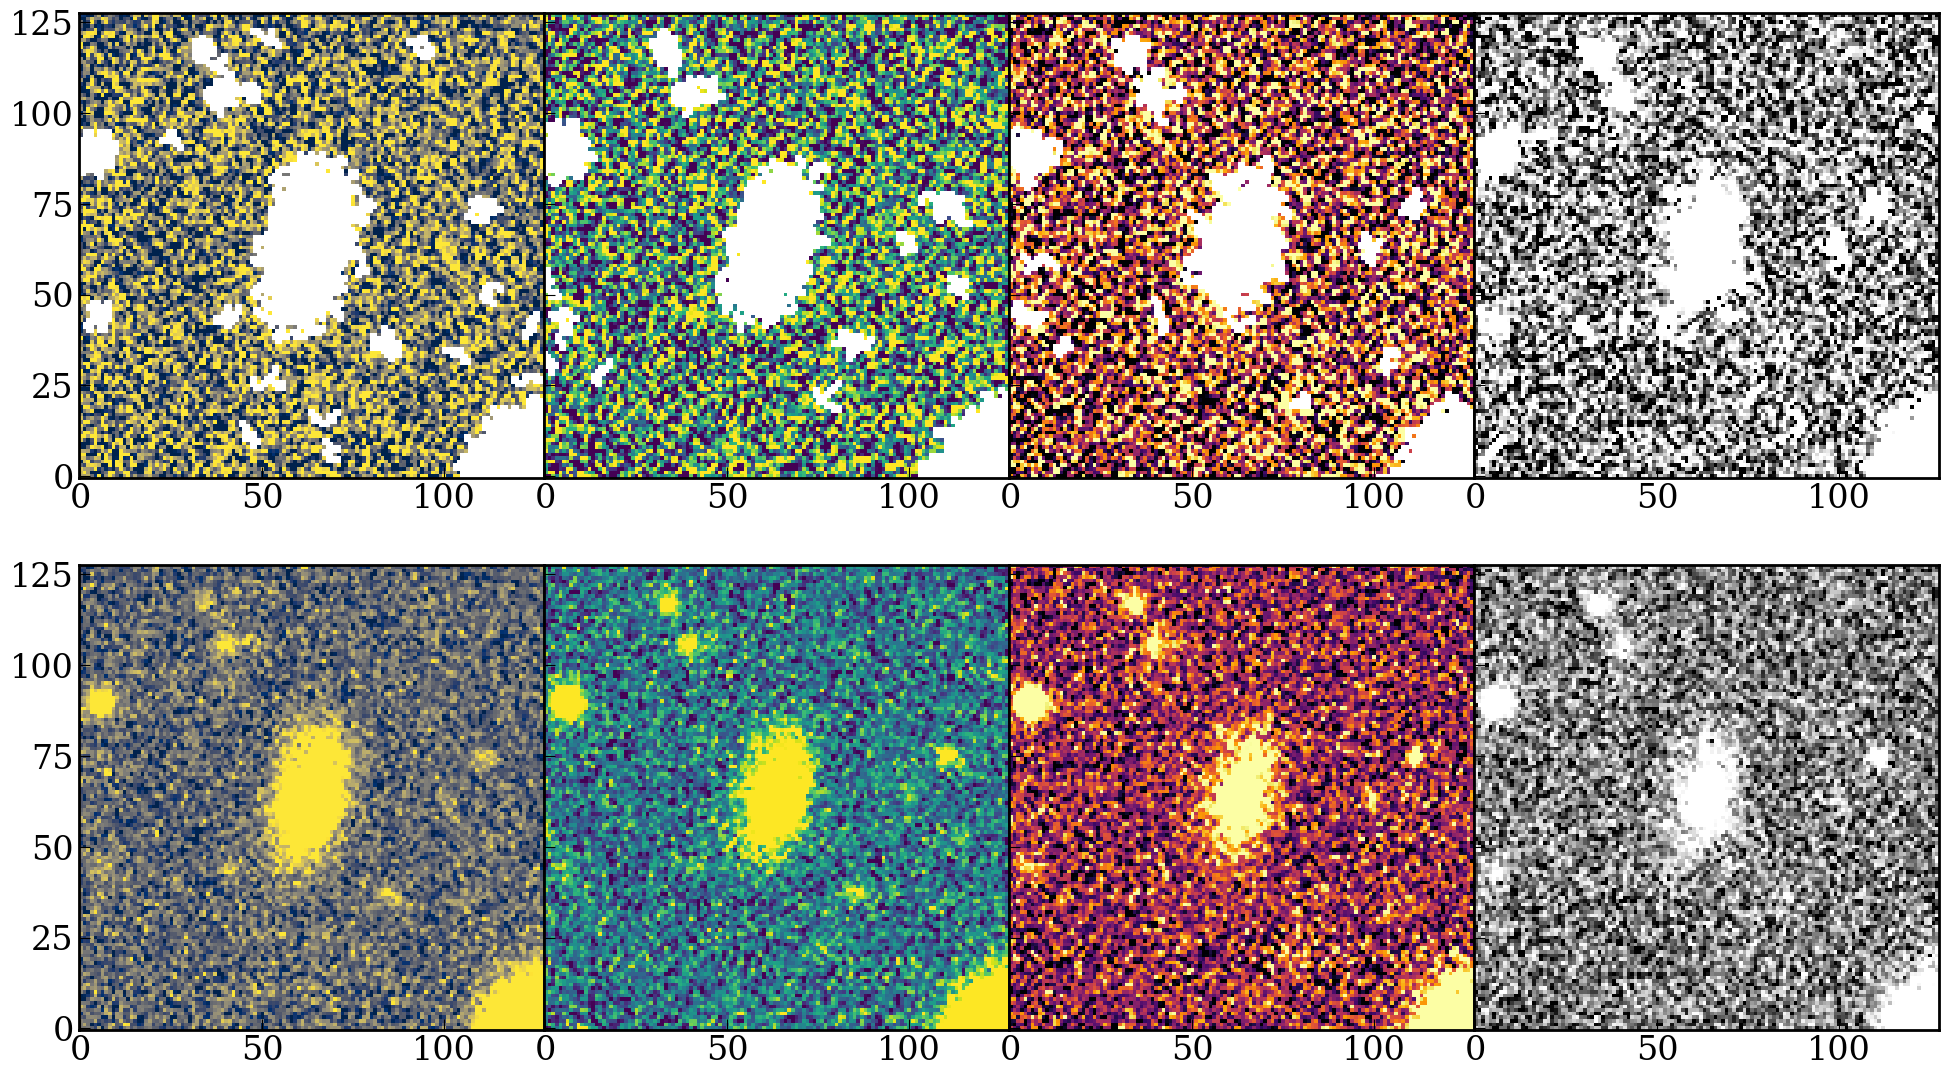

In [9]:

data = fits.open("cutouts/"+filename)

img_data,img_hdr,img_rms,glob_rms = image_bkg(data)

        

In [14]:
def rgb_cutout(img_data):
    imax = 0
    for img in img_data[::-1]:
        val = np.percentile(img,99.5)
        if val > imax: imax = val
    
    clip_intvls = 3*[ManualInterval(vmin=0, vmax=imax)]
    clip_intvls[2] = ManualInterval(vmin=0, vmax=100.)
    
    return make_rgb(img_data[2],img_data[1],img_data[0],interval=clip_intvls,stretch=LogStretch(a=50))

def gaussian_2d(x, y, x0=0.0, y0=0.0, sigma=1.0): return np.exp(-((x - x0)**2 + (y - y0)**2)/(2*sigma**2))

def psf_grid(d_psf,fwhm, psf_type='gaussian'):
    x = np.arange(-d_psf, d_psf+1)
    y = np.arange(-d_psf, d_psf+1)
    x_grid, y_grid = np.meshgrid(x, y)
    
    if psf_type=='gaussian':
            psf = gaussian_2d(x_grid, y_grid, sigma=fwhm)
            return psf/np.sum(psf)
    elif psf_type=='moffat':
            model = MoffatPSF(x_0=0.0, y_0=0.0, alpha=fwhm, beta=2.0)
            psf = model(x_grid, y_grid)
            return psf/np.sum(psf)


#fig,ax=plt.subplots(1,4,figsize=(24,8),sharey='row')
#for ii,key in enumerate(channels):
#    image_plot(ax[ii],model_psf,channels[key])
    

[63, 63]
0 False
1 False
2 True


TypeError: segment_img must be a SegmentationImage

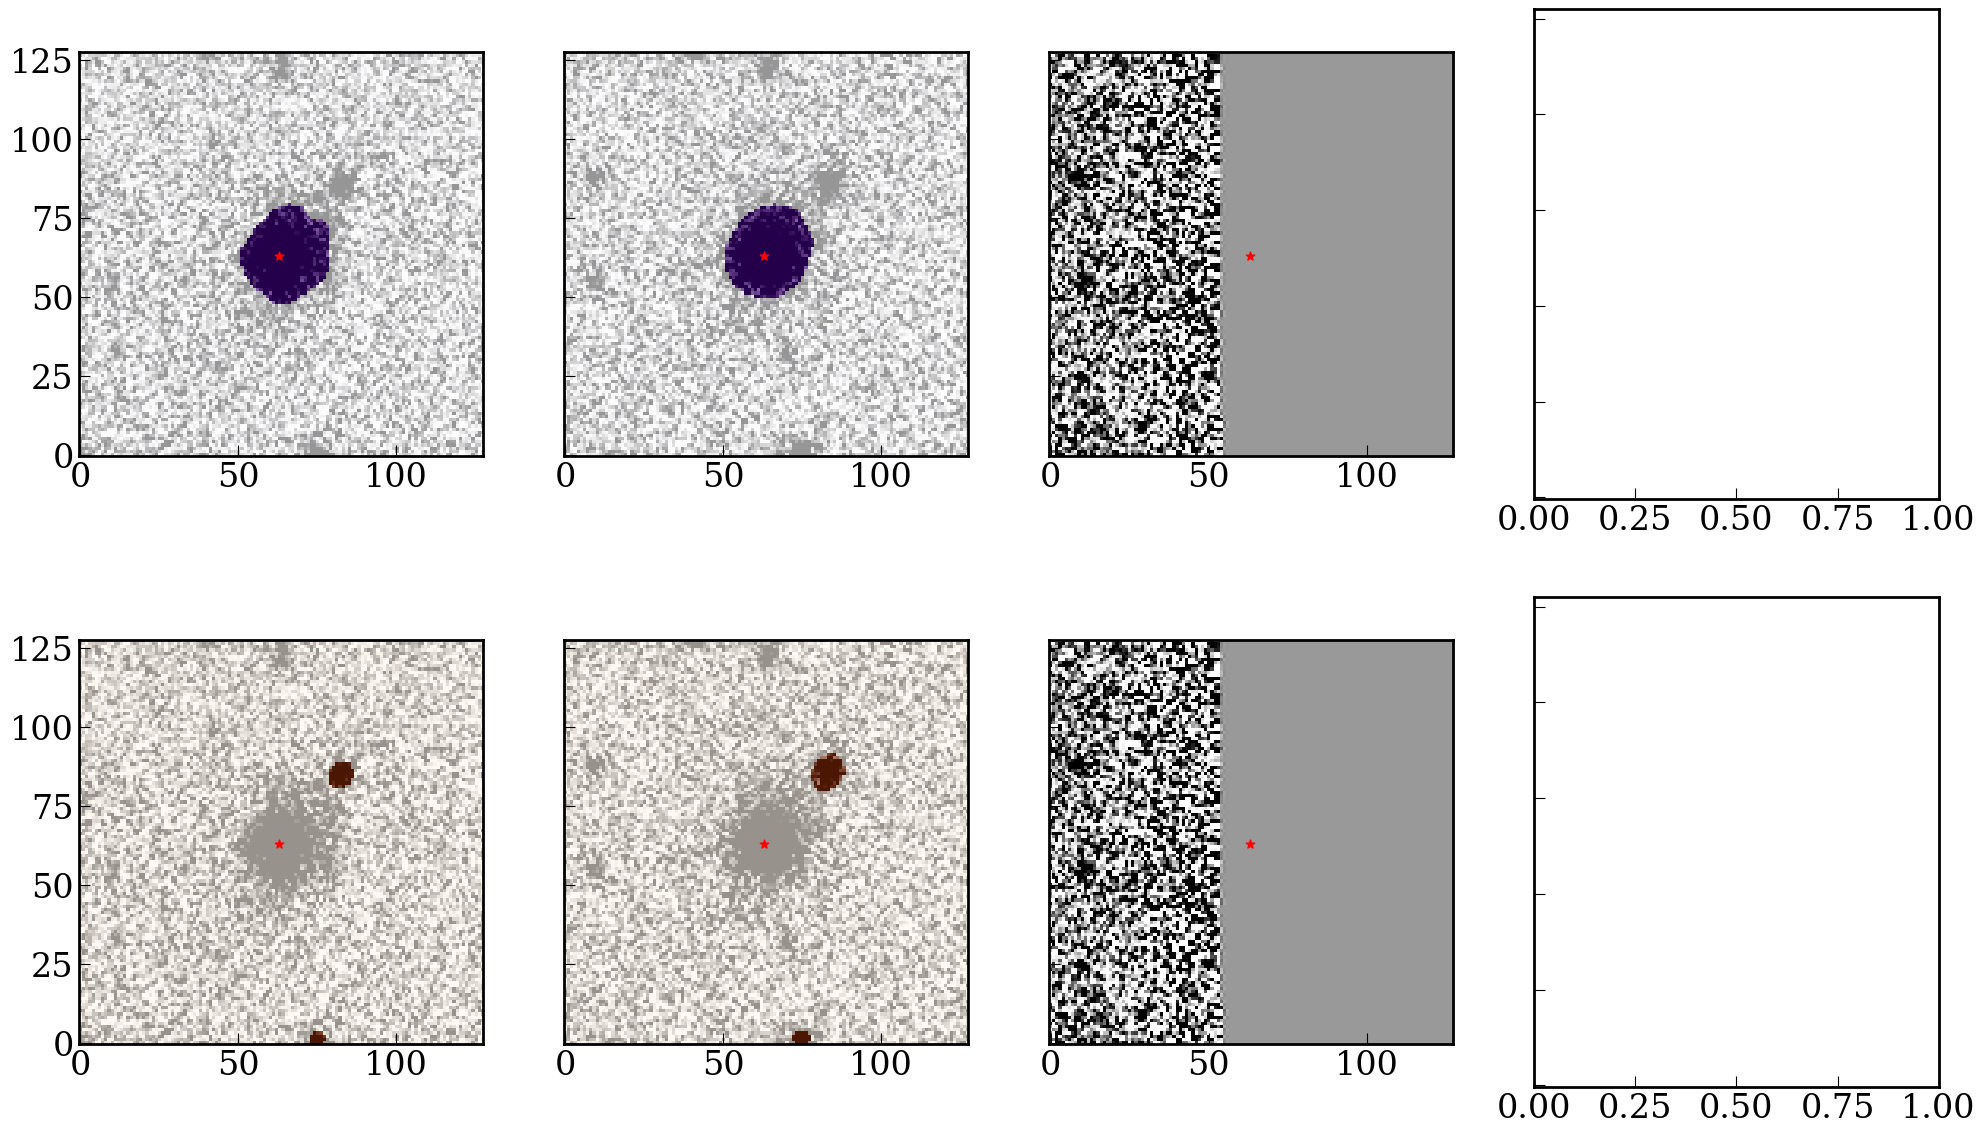

In [16]:
fig,ax=plt.subplots(2,4,figsize=(24,14),sharey=True)

w = wcs.WCS(img_hdr,naxis=2)
wc = [int(i) for i in w.world_to_pixel(pos_coord)]
print(wc)

model_psf = psf_grid(d_psf=8,fwhm=3)
segmaps_lo,segmaps_hi = [],[]
imzer = np.zeros((128,128))

for i,key in enumerate(channels):
    if np.any(img_data[i]>0):
        for j in range(2): 
            image_plot(ax[j,i],img_data[i],cmp=mcm.Greys)
            ax[j,i].scatter(wc[0], wc[1],marker='*',color='red',s=40,zorder=101)
      
        convolved_data = convolve(img_data[i], model_psf)

        finder = SourceFinder(npixels=10, nlevels=32, contrast=0.0005, progress_bar=False)
        segment_map = finder(convolved_data, img_rms[i])
        print(i,segment_map==None)

        cat = SourceCatalog(img_data[i], segment_map, convolved_data=convolved_data)
        tbl = cat.to_table()
        
        target = np.argmin(np.sqrt((tbl['xcentroid']-wc[0])**2+(tbl['ycentroid']-wc[1])**2))
        segmaps_lo.append(1*(segment_map==(target+1)))
        segmaps_hi.append(1*((segment_map!=imzer)&(segment_map!=(target+1))))
        
        ax[0,i].imshow(segmaps_lo[i], interpolation='nearest', cmap=mcm.Purples, origin='lower',alpha=0.6)
        ax[1,i].imshow(segmaps_hi[i], interpolation='nearest', cmap=mcm.Oranges, origin='lower',alpha=0.6)
'''
        finder = SourceFinder(npixels=10, nlevels=32, contrast=0.0005, progress_bar=False)
        segment_map = finder(convolved_data, 4*img_rms[i])

        tbl = SourceCatalog(img_data[i], segment_map, convolved_data=convolved_data).to_table()
        target = np.argmin(np.sqrt((tbl['xcentroid']-wc[0])**2+(tbl['ycentroid']-wc[1])**2))
        segmaps_hi.append(1*(segment_map==(target+1)))
        
        ax[1,i].imshow(segmaps_hi[i], interpolation='nearest', cmap=mcm.Oranges, origin='lower',alpha=0.4)
'''        

'''
        #objects,seg_map = sep.extract(img_data[i], 1, err=img_rms[i], segmentation_map=True,deblend_cont=0.0005,filter_type='matched',filter_kernel=model_psf)
        #segmaps_lo.append(1*(seg_map==(target+1)))
        
        #masked_segmap = nma.masked_array(seg_map, seg_map!=(target+1))
        ax[0,i].imshow(segmaps_lo[i], interpolation='nearest', cmap=mcm.Purples,vmin=0, vmax=len(objects), origin='lower',alpha=0.8)
        #ax[1,i].imshow(masked_segmap, cmap='hsv',  vmin=0, vmax=len(objects), origin='lower')

        objects,seg_map = sep.extract(img_data[i], 4, err=img_rms[i], segmentation_map=True,deblend_cont=0.001,filter_type='matched',filter_kernel=model_psf)
        target = np.argmin(np.sqrt((objects['x']-wc[0])**2+(objects['y']-wc[1])**2))
        print(i,objects['x'])
        
        segmaps_hi.append(1*(seg_map==(target+1)))
        ax[1,i].imshow(segmaps_hi[i], interpolation='nearest', cmap=mcm.Oranges,vmin=0, vmax=len(objects), origin='lower',alpha=0.6)
'''
comp_segmap = (segmaps_lo[0]&segmaps_lo[1])&(segmaps_lo[2]|segmaps_lo[3])

plt.subplots_adjust(wspace=0.0,hspace=0.05)
plt.show()

Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 12.79, sigma = 7.15
xc ---  Normal w/ mu = 63.88, sigma = 1.00
yc ---  Normal w/ mu = 63.47, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 8.78, sigma = 5.93, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 0.15 -> 8.00
sky type - flat
sky_back --- Normal with mu = 2.147e-04 and sd = 7.685e-05



/opt/anaconda3/envs/morphy/lib/python3.13/site-packages/pysersic/pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)
  1%|▎                   | 251/20000 [00:00<00:13, 1486.40it/s, Round = 2,step_size = 5.0e-04 loss: -7.330e+04]
/opt/anaconda3/envs/morphy/lib/python3.13/site-packages/pysersic/pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


2.58455 9.05832
Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 23.40, sigma = 9.67
xc ---  Normal w/ mu = 64.02, sigma = 1.00
yc ---  Normal w/ mu = 63.48, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 9.49, sigma = 6.16, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 0.15 -> 8.00
sky type - flat
sky_back --- Normal with mu = 4.544e-04 and sd = 1.202e-04



  1%|▎                   | 253/20000 [00:00<00:14, 1393.14it/s, Round = 2,step_size = 5.0e-04 loss: -6.642e+04]
/opt/anaconda3/envs/morphy/lib/python3.13/site-packages/pysersic/pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


2.20696 9.24105
Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 30.44, sigma = 11.03
xc ---  Normal w/ mu = 64.03, sigma = 1.00
yc ---  Normal w/ mu = 63.47, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 9.59, sigma = 6.20, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 0.15 -> 8.00
sky type - flat
sky_back --- Normal with mu = 6.092e-04 and sd = 1.970e-04



  1%|▎                   | 251/20000 [00:00<00:13, 1451.17it/s, Round = 2,step_size = 5.0e-04 loss: -5.888e+04]
/opt/anaconda3/envs/morphy/lib/python3.13/site-packages/pysersic/pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


2.80368 9.871099
Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 31.55, sigma = 11.23
xc ---  Normal w/ mu = 64.17, sigma = 1.00
yc ---  Normal w/ mu = 63.49, sigma = 1.00
r_eff ---  Truncated Normal w/ mu = 9.20, sigma = 6.07, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Uniform between: 0.00 -> 6.28
n ---  Uniform between: 0.15 -> 8.00
sky type - flat
sky_back --- Normal with mu = 1.041e-03 and sd = 3.825e-04



  2%|▎                   | 314/20000 [00:00<00:13, 1433.29it/s, Round = 2,step_size = 5.0e-04 loss: -4.804e+04]

3.31582 11.14538


NameError: name 't2' is not defined

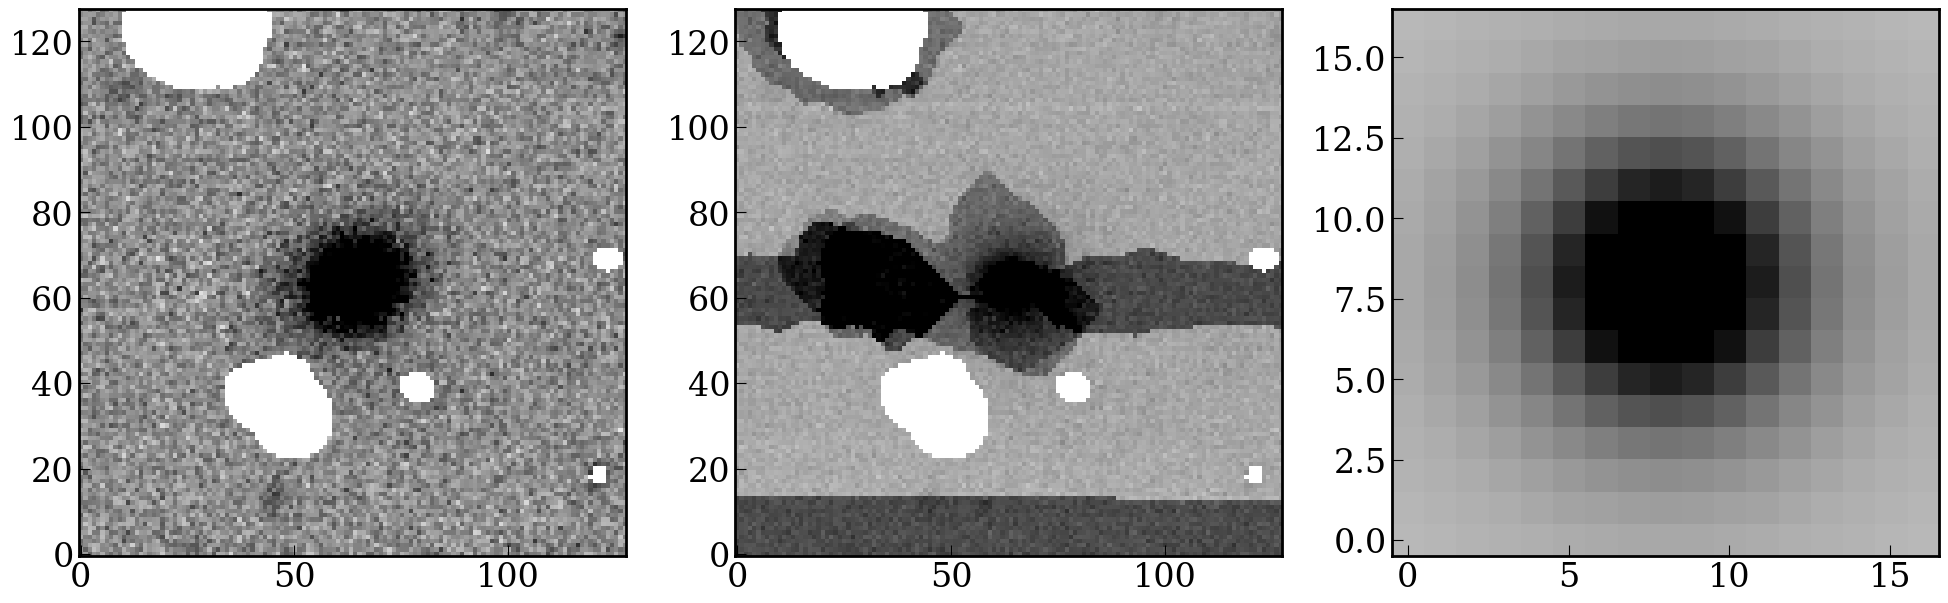

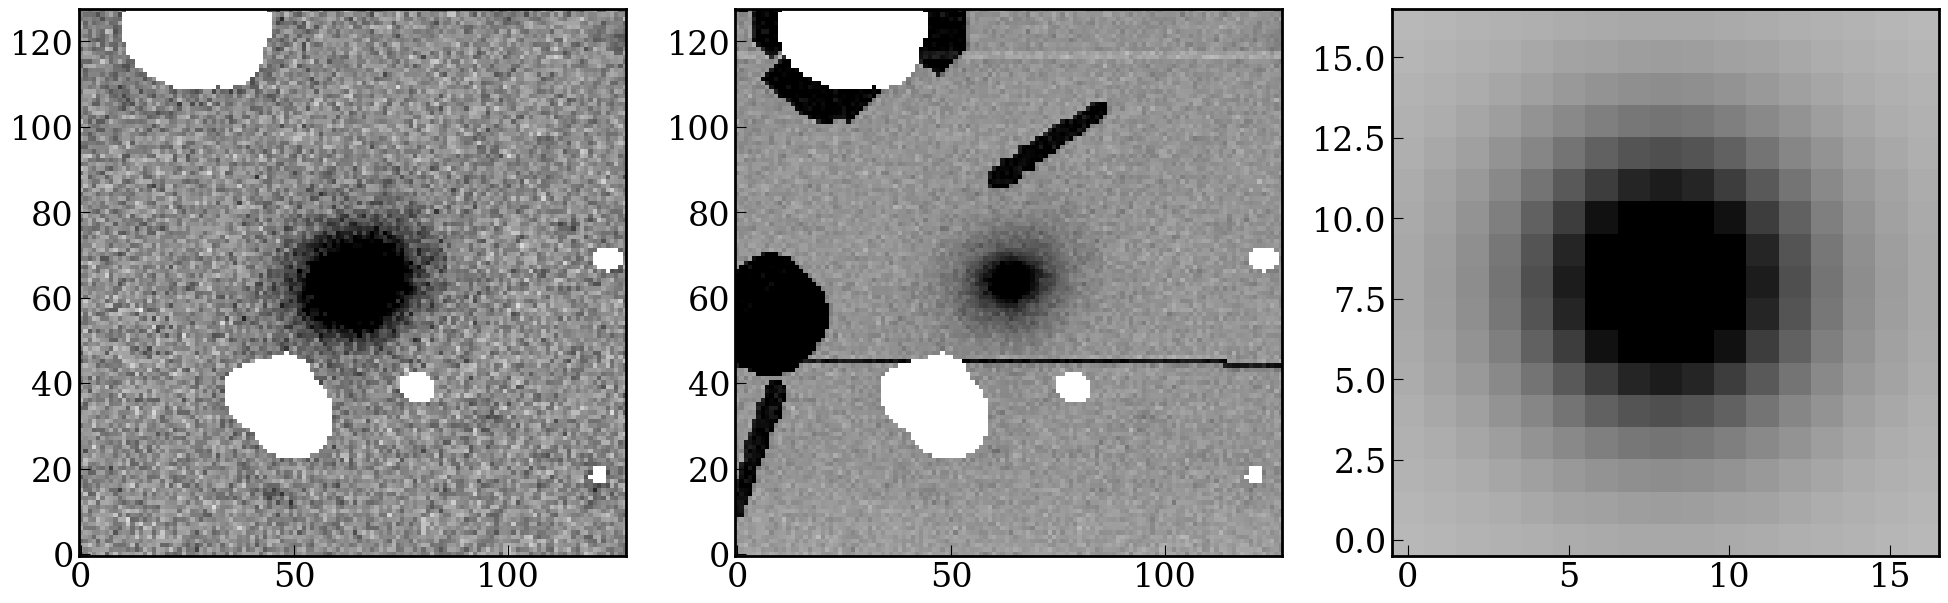

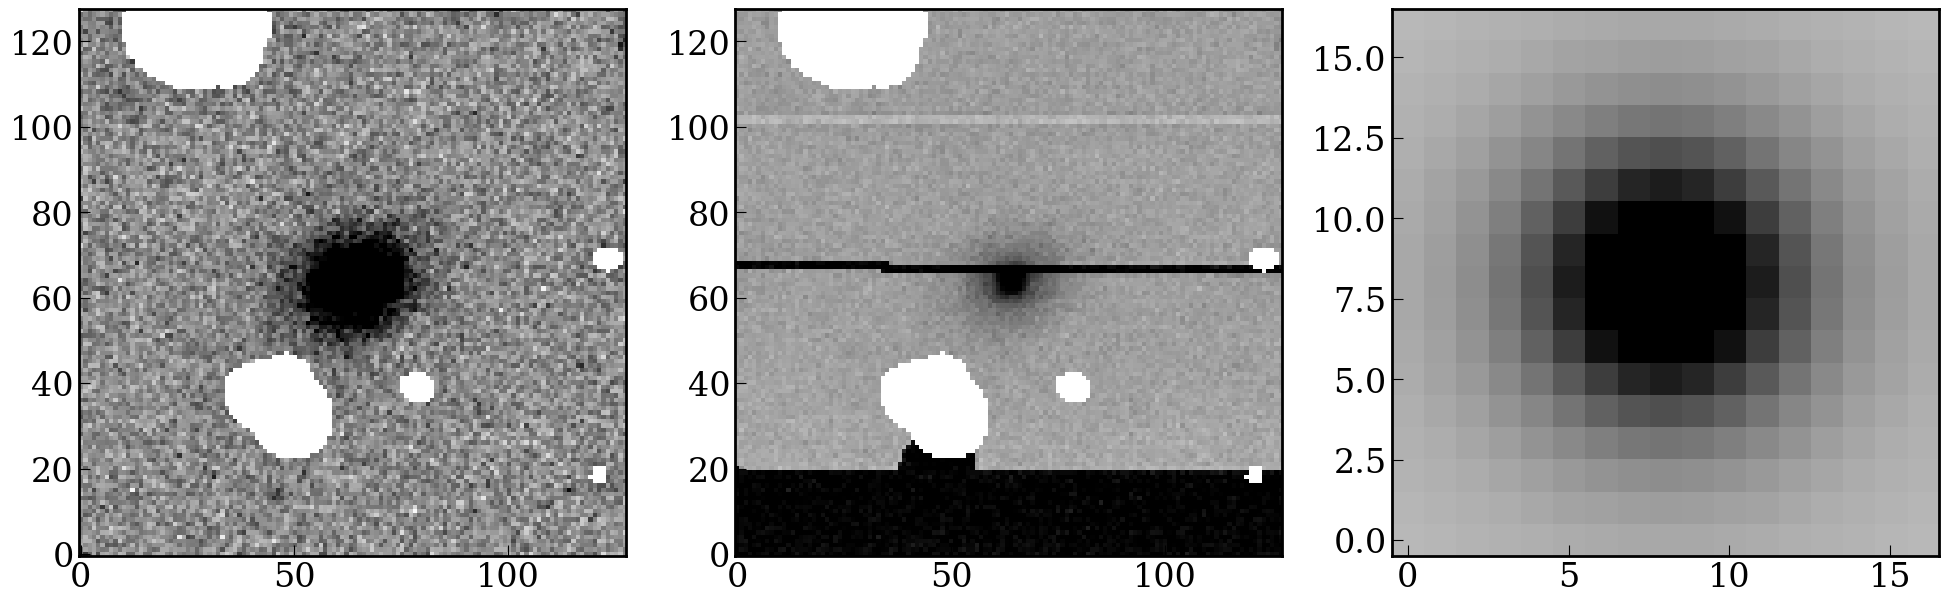

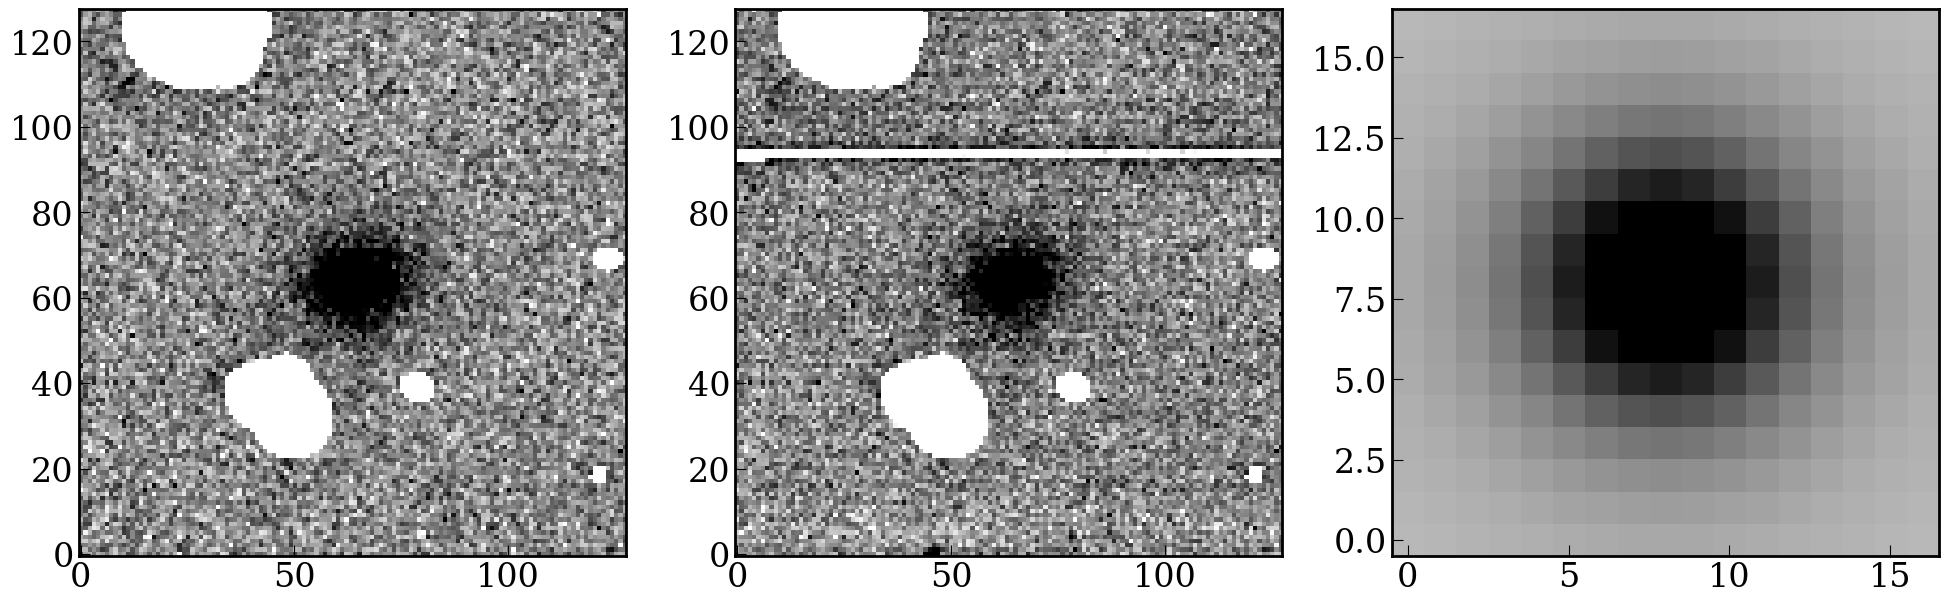

In [13]:

#fig,ax=plt.subplots(2,4,figsize=(24,14),sharey=True)

comp_segmaphi = (segmaps_hi[0]|segmaps_hi[1])|(segmaps_hi[2]|segmaps_hi[3])

#segmaps_lo,segmaps_hi = [],[]
imzer = np.zeros((128,128))

#t1 = time.time()


for i,key in enumerate(channels):
    if np.any(img_data[i]>0):
        #for j in range(2): 
        #    image_plot(ax[j,i],img_data[i],cmp=mcm.Greys)
        #    ax[j,i].scatter(wc[0], wc[1],marker='*',color='red',s=40,zorder=101)
        

        obs_psf = psf_grid(d_psf=8,fwhm=5,psf_type='moffat')
        plt.matshow(obs_psf)
        #print(check_input_data(data=img_data[i],rms=img_rms[i],psf=obs_psf,mask=mask))
        fig, ax = plot_image(img_data[i],comp_segmaphi,img_rms[i],obs_psf)
        
        prior  = autoprior(image = img_data[i], profile_type = 'sersic', mask=comp_segmaphi, sky_type = 'flat') 
        print(prior)
        fitter = FitSingle(data=img_data[i],rms=img_rms[i],mask=comp_segmaphi,psf=obs_psf,prior=prior,loss_func=student_t_loss)
        map_params = fitter.find_MAP(rkey = PRNGKey(1000))

        print(map_params['n'],map_params['r_eff'])
        #ax[0,i].imshow(mask, interpolation='nearest', cmap=mcm.Purples, origin='lower',alpha=0.6)


#t2 = time.time()

print('Time',t2-t1)

In [16]:
S = np.abs(np.multiply(img_data[2],comp_segmap))
N = np.multiply(img_rms[2],comp_segmap)

plt.imshow(S/N, cmap='inferno_r',origin='lower')
plt.colorbar()  

NameError: name 'comp_segmap' is not defined

In [12]:
def signal_to_noise(X,N,M):
    Y = np.abs(np.multiply(X,M))
    return np.sum(Y/N)/np.sum(M)

for i in range(4): 
    print(signal_to_noise(img_data[i],img_rms[i],comp_segmap))
    morph = smh.source_morphology(img_data[i], comp_segmap, weightmap=img_rms[i])[0]


9.48813817350943
6.260280748479341
5.28668390707921
3.0652295815291213


In [10]:
dir(statmorph)

['ConvolvedDoubleSersic2D',
 'ConvolvedSersic2D',
 'DoubleSersic2D',
 'SourceMorphology',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'source_morphology',
 'statmorph']

/var/folders/h6/wvvht_j93kdd56hj5zln7l_h0vlgf3/T/ipykernel_86833/1669773622.py:7: RuntimeWarning: invalid value encountered in divide
  plt.imshow(S/N, cmap='inferno_r',origin='lower')


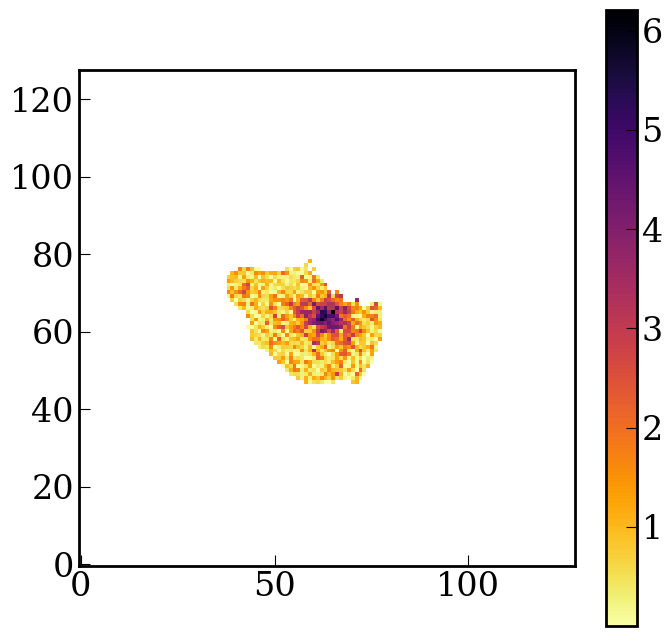

[-365560, 378955]


Deblending:   0%|          | 0/3 [00:00<?, ?it/s]

Num of Targets: 3
26.1152 ± nan pix


Deblending:   0%|          | 0/3 [00:00<?, ?it/s]

Num of Targets: 5
24.7750 ± nan pix


Deblending:   0%|          | 0/3 [00:00<?, ?it/s]

Num of Targets: 5
25.7752 ± nan pix


Deblending:   0%|          | 0/3 [00:00<?, ?it/s]

Num of Targets: 4
24.2348 ± nan pix


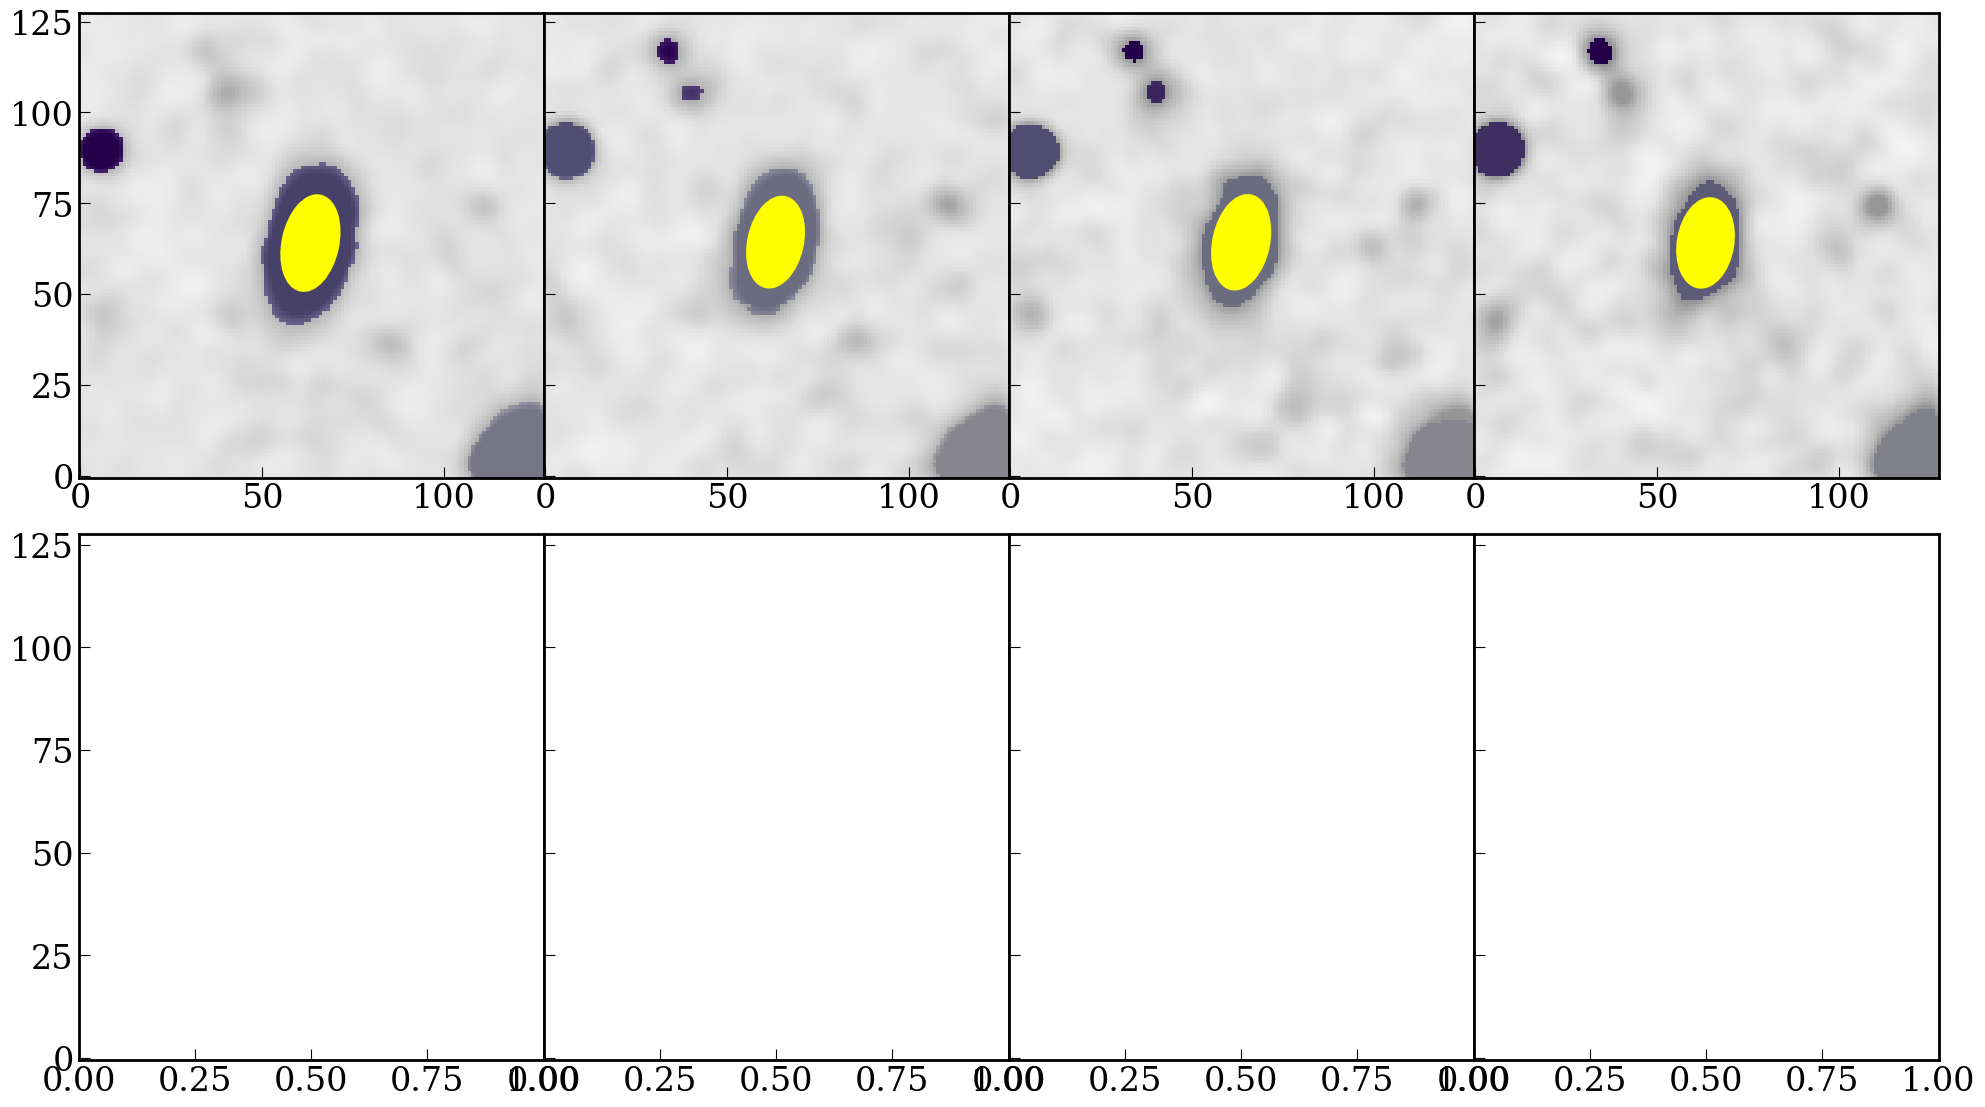

In [18]:

from astropy.convolution import convolve

fig,ax=plt.subplots(2,4,figsize=(24,14),sharey=True)

w = wcs.WCS(img_hdr,naxis=2)
wc = [int(i) for i in w.world_to_pixel(pos_coord)]
print(wc)
model_psf = psf_grid(d_psf=8,fwhm=3)

max_pix = 50
r_list = pf.make_radius_list(max_pix=max_pix, # Max pixel to go up to
                                     n=max_pix # the number of radii to produce (i.e 1 aperture per pixel increase in r)
        )

segmaps_lo,segmaps_hi = [],[]

for i,key in enumerate(channels):
    if np.any(img_data[i]>0):
        for j in range(1): 
            result = convolve(img_data[i], model_psf)
            
            image_plot(ax[j,i],result,cmp=mcm.Greys)
            ax[j,i].scatter(wc[0], wc[1],marker='*',color='red',s=40,zorder=101)

        #image_mean, image_median, image_stddev = sigma_clipped_stats(img_data[i], sigma=3)
        
        cat, segm, segm_deblend = pf.make_catalog(result,1*img_rms[i],wcs=None,deblend=True,npixels=20,nlevels=30,contrast=0.001,plot=False)
        sorted_idx_list = pf.order_cat(cat, key='area', reverse=True)

        print("Num of Targets:", len(cat))

        ax[0,i].imshow(segm_deblend, interpolation='nearest', cmap=mcm.Purples,vmin=0, vmax=len(cat), origin='lower',alpha=0.6)

        source = cat[sorted_idx_list[0]]  # get source from the catalog
                
        # Photomerty
        flux_arr, area_arr, error_arr = pf.source_photometry(
            # Inputs
            source, # Source (`photutils.segmentation.catalog.SourceCatalog`)
            result, # Image as 2D array
            segm_deblend, # Deblended segmentation map of image
        
            r_list, # list of aperture radii
            error=img_rms[i], # Error image (optional)

        )

        p = pf.Petrosian(r_list, area_arr, flux_arr, flux_err=error_arr)
        print("{:0.4f} ± {:0.4f} pix".format(p.r_petrosian, p.r_petrosian_err))

        x0,y0 = source.to_table()['xcentroid'][0],source.to_table()['ycentroid'][0] 	
        eccn,theta = source.to_table()['eccentricity'][0],source.to_table()['orientation'][0].value

        ellipse = Ellipse((x0,y0), p.r_petrosian, p.r_petrosian*np.sqrt(1-eccn*eccn), angle=theta,lw=3,color='yellow')
        ax[0,i].add_artist(ellipse)
    
plt.subplots_adjust(wspace=0.0,hspace=0.05)
plt.show()

In [7]:
dir(pf)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

2.0
2.0
1.0
1.0


"\nprint('BASIC MEASUREMENTS (NON-PARAMETRIC)')\nprint('xc_centroid =', morph.xc_centroid)\nprint('yc_centroid =', morph.yc_centroid)\nprint('ellipticity_centroid =', morph.ellipticity_centroid)\nprint('elongation_centroid =', morph.elongation_centroid)\nprint('orientation_centroid =', morph.orientation_centroid)\nprint('xc_asymmetry =', morph.xc_asymmetry)\nprint('yc_asymmetry =', morph.yc_asymmetry)\nprint('ellipticity_asymmetry =', morph.ellipticity_asymmetry)\nprint('elongation_asymmetry =', morph.elongation_asymmetry)\nprint('orientation_asymmetry =', morph.orientation_asymmetry)\nprint('rpetro_circ =', morph.rpetro_circ)\nprint('rpetro_ellip =', morph.rpetro_ellip)\nprint('rhalf_circ =', morph.rhalf_circ)\nprint('rhalf_ellip =', morph.rhalf_ellip)\nprint('r20 =', morph.r20)\nprint('r80 =', morph.r80)\nprint('Gini =', morph.gini)\nprint('M20 =', morph.m20)\nprint('F(G, M20) =', morph.gini_m20_bulge)\nprint('S(G, M20) =', morph.gini_m20_merger)\nprint('sn_per_pixel =', morph.sn_per

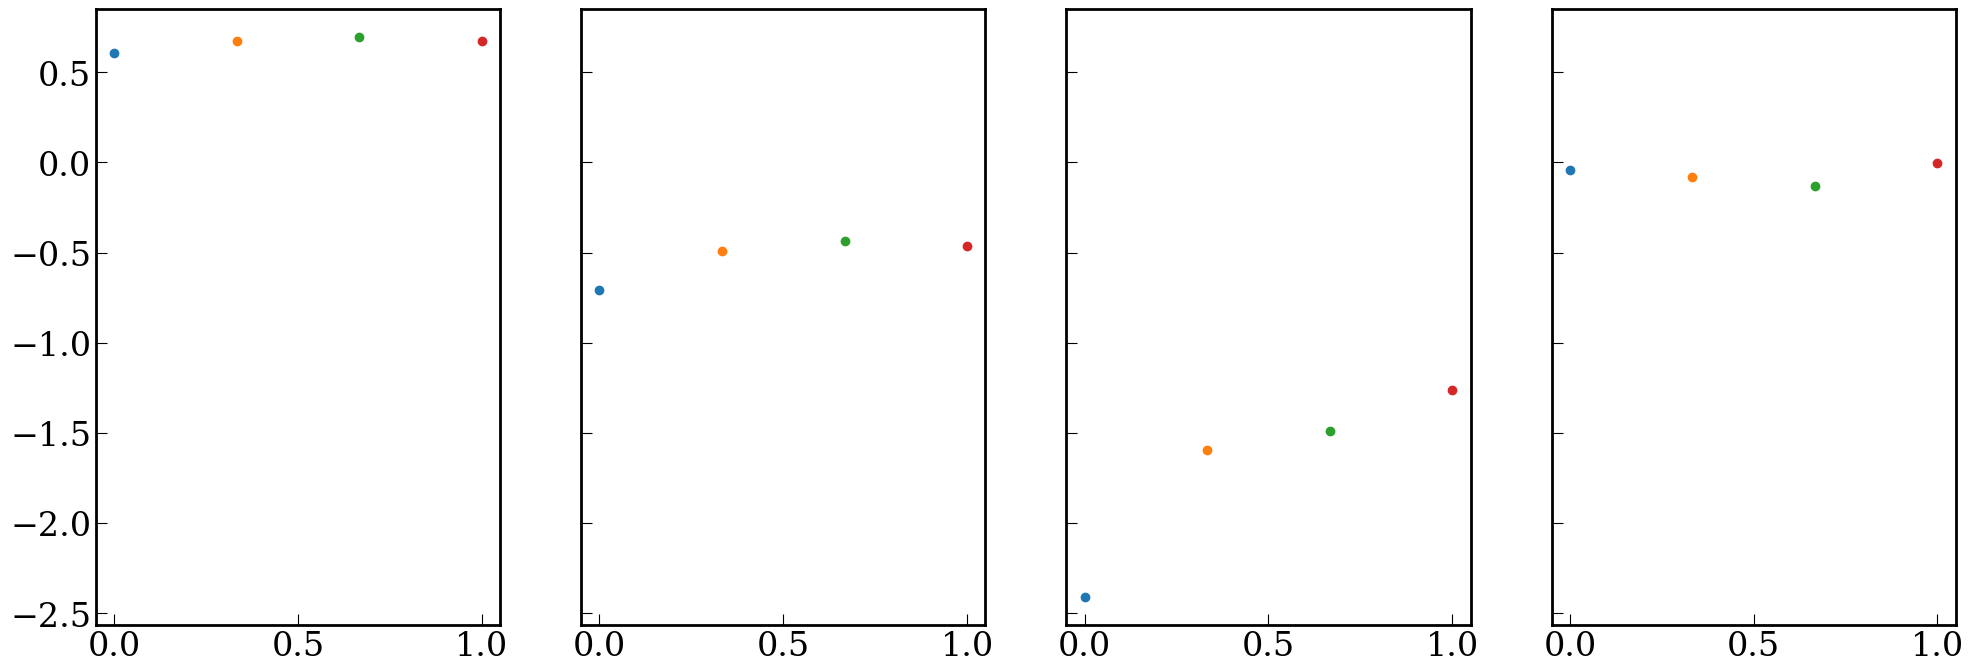

In [52]:
morph_arr = np.zeros((4,8))
for i,key in enumerate(channels):
    morph = statmorph.source_morphology(img_data[i], comp_segmap, weightmap=img_rms[i])[0]

    morph_arr[i,:] = morph.gini,morph.m20,morph.gini_m20_bulge,morph.gini_m20_merger,morph.concentration,morph.asymmetry,morph.smoothness,morph.flag

fig,ax=plt.subplots(1,4,figsize=(24,8),sharey=True)

mag_rang = np.linspace(0,1,4)
for i in range(4):
    print(morph_arr[i,-1])
    ax[0].plot(mag_rang[i],morph_arr[i,0],marker='o')
    ax[1].plot(mag_rang[i],morph_arr[i,1],marker='o')
    ax[2].plot(mag_rang[i],morph_arr[i,5],marker='o')
    ax[3].plot(mag_rang[i],morph_arr[i,6],marker='o')



'''
print('BASIC MEASUREMENTS (NON-PARAMETRIC)')
print('xc_centroid =', morph.xc_centroid)
print('yc_centroid =', morph.yc_centroid)
print('ellipticity_centroid =', morph.ellipticity_centroid)
print('elongation_centroid =', morph.elongation_centroid)
print('orientation_centroid =', morph.orientation_centroid)
print('xc_asymmetry =', morph.xc_asymmetry)
print('yc_asymmetry =', morph.yc_asymmetry)
print('ellipticity_asymmetry =', morph.ellipticity_asymmetry)
print('elongation_asymmetry =', morph.elongation_asymmetry)
print('orientation_asymmetry =', morph.orientation_asymmetry)
print('rpetro_circ =', morph.rpetro_circ)
print('rpetro_ellip =', morph.rpetro_ellip)
print('rhalf_circ =', morph.rhalf_circ)
print('rhalf_ellip =', morph.rhalf_ellip)
print('r20 =', morph.r20)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('M20 =', morph.m20)
print('F(G, M20) =', morph.gini_m20_bulge)
print('S(G, M20) =', morph.gini_m20_merger)
print('sn_per_pixel =', morph.sn_per_pixel)
print('C =', morph.concentration)
print('A =', morph.asymmetry)
print('S =', morph.smoothness)
print('sky_mean =', morph.sky_mean)
print('sky_median =', morph.sky_median)
print('sky_sigma =', morph.sky_sigma)
print('flag =', morph.flag)
print('flag_sersic =', morph.flag_sersic)
'''

In [ ]:
from scipy.interpolate import RectBivariateSpline as RBS

def get_star_psf(ns_pos):
        ns_coord = SkyCoord(ra=ns_pos[0]*u.degree, dec=ns_pos[1]*u.degree, frame='icrs')

        download_cutout(ns_pos.reshape(1,2),size=32,out_dir='bright_stars/')
        star_dat = fits.open('bright_stars/cutout_{:.4f}_{:.4f}.fits'.format(ns_pos[0],ns_pos[1]))
        star_arr = star_dat[0].data
        star_hdr = star_dat[0].header

        nw = wcs.WCS(star_hdr,naxis=2)
        nsp2 = [int(i) for i in nw.world_to_pixel(ns_coord)]
        d_psf = 6 # in pixels, the size of the cutout
        
        star_data,star_hdr,star_rms,glob_rms = image_bkg(star_dat[0])
        
        fig,ax=plt.subplots(1,4,figsize=(24,8),sharey='row')
        #fig = plt.figure(figsize=(6*len(c),14)) 
        
        psfs = []
        for jj,ley in enumerate(channels):
            if np.any(star_data[jj]>0):
                #image_plot(ax[ii],star_arr[ii,:,:],channels[key])
            
                objects = sep.extract(star_data[jj], 5, err=star_rms[jj])
                target = np.argmin(np.sqrt((objects['x']-nsp2[0])**2+(objects['y']-nsp2[1])**2))
            
                #ax[ii].scatter(objects['x'][target],objects['y'][target],marker='*',color='red',s=50)
                nsp2[0],nsp2[1] = objects['x'][target],objects['y'][target]
                
                model = star_data[jj][(round(nsp2[1])-d_psf):(round(nsp2[1])+d_psf+1), (round(nsp2[0])-d_psf):(round(nsp2[0])+d_psf+1)]
                model = np.copy(model)
            
                # now we center the psf model via interpolation
                x = np.arange(-d_psf, d_psf+1)
                y = np.arange(-d_psf, d_psf+1)
                model_interp = RBS(y, x, model)
            
                xcen = nsp2[0] - round(nsp2[0])
                ycen = nsp2[1] - round(nsp2[1])
            
                xi = np.arange(xcen-d_psf+1, xcen+d_psf)
                yi = np.arange(ycen-d_psf+1, ycen+d_psf)
            
                model_2 = model_interp(yi, xi)
                model_2 /= np.sum(model_2)
            
                image_plot(ax[jj],model_2,channels[ley])
            
                psfs.append(model_2)


In [ ]:
kronrad, krflag = sep.kron_radius(data, x, y, a, b, theta, 6.0)
flux, fluxerr, flag = sep.sum_ellipse(data, x, y, a, b, theta, 2.5*kronrad,subpix=1)

flag |= krflag

In [ ]:
seg_id = np.arange(1, len(objs)+1, dtype=np.int32)

r, flag = sep.flux_radius(data, objs['x'], objs['y'], 6.*objs['a'],
                          0.5, seg_id=seg_id, seg=seg,
                          normflux=flux, subpix=5)

In [ ]:
out_dir='bricks/'
    
bricks = fits.open("survey-bricks-dr10-south.fits")[1].data
sel = (bricks['DEC1'] < pos[1]) & (bricks['DEC2'] > pos[1]) & (bricks['RA1'] < pos[0]) & (bricks['RA2'] > pos[0])
brickname = bricks[sel]['BRICKNAME'][0]
print(brickname)
mask,mask_hdr = load_mask(brickname)

w = wcs.WCS(mask_hdr)
wc = [int(i) for i in w.world_to_pixel(pos_coord)]
print(wc)

reduced_mask = mask[wc[0]-64:wc[0]+64, wc[1]-64:wc[1]+64]
print(np.shape(reduced_mask))

ax = plt.subplot(projection=w)

image_plot(ax,mask,'viridis')
ax.scatter(wc[0], wc[1],marker='*',color='cyan',s=80)
ax.add_patch( Rectangle((wc[0]-64, wc[1]-64),  128, 128, fc ='none',  ec ='black', lw = 3) )


url = 'https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr10/south/tractor/' + brickname[:3] + '/'
filename = 'tractor-' + brickname + '.fits'

request_apply(url+filename,filename,out_dir) 

# will load tractor into a dataframe instead of fits table for ease
filename = out_dir + filename
dat = fits.open(filename)

tract = pd.DataFrame({'objid':dat[1].data['objid'].byteswap().newbyteorder()})

# will go through each of these and load into a column in the dataframe. have to 'swap the byte order' for some reason..
keys = ['ra', 'dec', 'brickname', 'type', 'flux_z','flux_g','ebv','bx', 'by',]

for key in keys:
    tract[key] = dat[1].data[key].byteswap().newbyteorder()

tract['m_g0'] = -2.5*np.log10(tract['flux_g']) + 22.5 - tract['ebv'] * 3.214
tract['m_z0'] = -2.5*np.log10(tract['flux_z']) + 22.5 - tract['ebv'] * 1.211


stars = tract.loc[(tract['type'] =='PSF') & (tract['m_g0']<21) & (tract['m_g0']>17.5) & (tract['m_z0']<21) & (tract['ra']>(pos[0]-0.1)) & (tract['ra']<(pos[0]+0.1)) & (tract['dec']>(pos[1]-0.1)) & (tract['dec']<(pos[1]+0.1))]


stars['isolated'] = False
stars['masked'] = True
tree = KDTree(tract[['bx', 'by']].to_numpy())

for ii in range(len(stars)):
        cds = [stars['bx'].values[ii], stars['by'].values[ii]]
        rad = 20 #pixels, this is the isolation criterion
        idx = tree.query_ball_point(cds, rad)
        stars.iloc[ii, stars.columns.get_loc('isolated')] = len(idx) == 1


masked_pix = np.where(mask > 1)
masked_pix = np.vstack((masked_pix[1], masked_pix[0])).T
tree = KDTree(masked_pix)

for ii in range(len(stars)):
        cds = [stars['bx'].values[ii], stars['by'].values[ii]]
        rad = 10 #pixels; this is the isolation criterion from a masked pix
        idx = tree.query_ball_point(cds, rad)
        stars.iloc[ii, stars.columns.get_loc('masked')] = len(idx) > 0


stars = stars[(stars['isolated'] == True) & (stars['masked'] == False)]
print(len(stars), ' isolated stars found')

#pix_coords = w.all_world2pix([wc], 1)[0]
w = wcs.WCS(img_hdr,naxis=2)


# now we find the closest isolated star to this location and will use that as the PSF model
coords = stars[['ra', 'dec']].to_numpy()
dist_min = np.argmin(np.sqrt((coords[:,0]-wc[0])**2 + (coords[:,1]-wc[1])**2))
ns_pos = coords[dist_min]
ns_coord = SkyCoord(ra=ns_pos[0]*u.degree, dec=ns_pos[1]*u.degree, frame='icrs')

print(ns_coord)

nsp = [int(i) for i in w.world_to_pixel(ns_coord)]
print('brightest star pixel nearest at, ', nsp)

ax = plt.subplot(projection=w)
image_plot(ax,img_data[0,:,:],'cividis')


for i,star in stars.iterrows():
    #print(star['ra'],star['dec'])
    
    c = SkyCoord(ra=star['ra']*u.degree, dec=star['dec']*u.degree, frame='icrs')
    wc = [int(i) for i in w.world_to_pixel(c)]
    
    ax.scatter(wc[0],wc[1] ,marker='o',color='red',s=50)

wc = [int(i) for i in w.world_to_pixel(ns_coord)]
ax.scatter(wc[0],wc[1],marker='o',color='blue',s=40,zorder=101)



In [ ]:
from scipy.interpolate import RectBivariateSpline as RBS

#print(ns_pos,nsp2[0],nsp2[1])
ns_pos = np.array([8.1518878,-64.6239332])
ns_coord = SkyCoord(ra=ns_pos[0]*u.degree, dec=ns_pos[1]*u.degree, frame='icrs')
download_cutout(ns_pos.reshape(1,2),size=32,out_dir='bright_stars/')

ns_ra,ns_dec = str(np.round(ns_pos[0],4)),str(np.round(ns_pos[1],4))
star_dat = fits.open('bright_stars/cutout_'+ns_ra+'_'+ns_dec+'.fits')
star_arr = star_dat[0].data
star_hdr = star_dat[0].header

nw = wcs.WCS(star_hdr,naxis=2)
nsp2 = [int(i) for i in nw.world_to_pixel(ns_coord)]
print(nsp2)
d_psf = 6 # in pixels, the size of the cutout

star_data,star_hdr,star_rms,glob_rms = image_bkg(star_dat[0])

fig,ax=plt.subplots(1,4,figsize=(24,8),sharey='row')
#fig = plt.figure(figsize=(6*len(c),14)) 

psfs = []
for ii,key in enumerate(channels):
    print(ii)
    if np.any(img_data[ii]>0):
        #image_plot(ax[ii],star_arr[ii,:,:],channels[key])
    
        objects = sep.extract(star_data[ii], 5, err=star_rms[ii])
        try: 
            target = np.argmin(np.sqrt((objects['x']-nsp2[0])**2+(objects['y']-nsp2[1])**2))
            nsp2[0],nsp2[1] = objects['x'][target],objects['y'][target]
        except: print()
    
        #ax[ii].scatter(objects['x'][target],objects['y'][target],marker='*',color='red',s=50)
        
        
        model = star_data[ii][(round(nsp2[1])-d_psf):(round(nsp2[1])+d_psf+1), (round(nsp2[0])-d_psf):(round(nsp2[0])+d_psf+1)]
        model = np.copy(model)
    
        # now we center the psf model via interpolation
        c
        model_interp = RBS(y, x, model)
    
        xcen = nsp2[0] - round(nsp2[0])
        ycen = nsp2[1] - round(nsp2[1])
    
        xi = np.arange(xcen-d_psf+1, xcen+d_psf)
        yi = np.arange(ycen-d_psf+1, ycen+d_psf)
    
        model_2 = model_interp(yi, xi)
        model_2 /= np.sum(model_2)
    
        image_plot(ax[ii],model_2,channels[key])
    
        psfs.append(model_2)
